# Machine Learning used to build a Diversified Portfolio: K-Means Clustering



In [77]:
#!pip install kneed
#!pip install finviz
#!pip install yfinance

In [110]:
import time
import kneed
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import ipywidgets as widgets 
from scipy.stats import mstats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
from requests.adapters import HTTPAdapter
from requests.exceptions import ConnectionError
from requests.packages.urllib3.util.retry import Retry

<a name="application"></a>
<h2><span style="color:black">K-Means Clustering Application: Building a diversified portfolio </span></h2>

We are going to use K-Means Clustering to build a diversified portfolio. Two ratios will be used in order to cluster the data: <BR>
<ul>
    <li> <code>Revenue per share:</code> Amount of sales or revenues generated per average total shares outstanding. (Sales Revenue/Average Total Shares)</li>
    <li><code>Return on Assets:</code> Indicator of how profitable company is relative to its assets (Total Income /Total Assets)</li>

</ul>
The idea is to create clusters with similar characteristics for the components of the S&P 500 using these two factors at the end of the 2021 Q3. From each cluster, we will take the stocks with highest risk adjusted momentum to build our portfolio. <br><br>
   After building this portfolio, we will run it for 2022 Q1 and compare it to the return of the S&P 500.<br><br>
    
Please note that this analysis is done using only two factors which leads to a two dimensional problem. We are using a two dimensional problem to demonstrate the concept and understand the problem. Multiple factors can be used as well. If you want to use multiple factors, you may want to use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html">Principal Component Analysis</a> to lower the number of dimensions. <br><br>
   
We will proceed with the following steps: <br><b>K-Means Clustering : </b><br>

    1. Get the data: Revenue per share and Return on Assets for the end of 2021 Q1 for members of the S&P 500.
    2. Analyze the data, clean it and visualize it.
    3. Choose K.
    4. Analyze the clustering results.
<b>Portfolio Construction : </b><br>
    
    1. From each cluster, choose the stocks with the highest risk adjusted momentum. 
    2. Run the portfolio return for 2021-Q2.

----
## K-Means Clustering 
### <I>1. Get the data: Revenue per share and Return on Assets for members of the S&P 500</I>

In [111]:
import finviz
import numpy as np 
import pandas as pd 

In [ ]:
# Scrape the S&P 500 tickers from Wikipedia

def get_tickers():
    wiki_page = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies').text
    sp_data = pd.read_html(wiki_page)
    ticker_df = sp_data[0]
    ticker_options = ticker_df['Symbol']
    return ticker_options

In [ ]:
# Run the ticker scrape function
# Let's convert the get_tickers() output to a list and 

stock_tickers = get_tickers()
stock_tickers = stock_tickers.to_list()
for ticker in range(len(stock_tickers)):
    stock_tickers[ticker] = stock_tickers[ticker].upper().replace(".", "-")

print (len(stock_tickers))
# stock_tickers

505


In [ ]:
stock_tickers[0:10]

['MMM', 'AOS', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP']

In [ ]:
# Get information for the stocks and put in dataframe
def get_fundamental_data(df):
    for symbol in df.index:
        try:
            stock_info = finviz.get_stock(symbol)
            for m in df.columns:                
                df.loc[symbol,m] = stock_info[m]               
        except:
            print (symbol, 'not found')
    return df

In [ ]:
# Define the list of stocks to get information from
stock_symbol_list = ['FTI','VTRS','LUMN','AMCR','HBAN','HPE','UA','AAL','F','UAA','KMI','NLSN','HST','NCLH','CCL','PBCT','IVZ','AES','NWSA','NWS','RF','MRO','NWL','KIM','KEY','CTRA','T','PPL','CNP','DISCK','DISCA','BKR','BEN','NI','NLOK','PEAK','DXC','DISH','HAL','WMB','PARA','ROL','JNPR','HWM','CSX','HPQ','CAG','TWTR','IPG','NRG','SLB','APA','OGN','DAL','FOX','GLW','WY','BWA','KHC','TPR','SYF','LVS','IP','FE','FOXA','UAL','LUV','VNO','MGM','BAC','EXC','BSX','WRK','CARR','FITB','GM','CPB','WBA','PFE','LKQ','CMCSA','INTC','OXY','CEG','FCX','KR','CFG','IR','WDC','HRL','IRM','PHM','BK','WFC','TAP','PENN','CTVA','MO','BBWI','FAST','MOS','CAH','ALK','DRE','VTR','VZ','USB','UDR','XRAY','EBAY','MAS','CSCO','VFC','PNR','DOW','LNT','AIG','TFC','DVN','C','AFL','L','GILD','EVRG','KO','LNC','JCI','OKE','FTV','EIX','SO','K','CMS','LW','MET','PEG','TJX','MDLZ','ZION','BF-B','REG','O','SEE','HIG','XEL','AOS','GIS','PFG','BRO','MCHP','BMY','NEM','TRMB','PNW','INCY','TXT','HOLX','CDAY','RCL','APH','MPC','DD','CL','ORCL','MRK','SCHW','NTAP','OTIS','NEE','ADM','XOM','D','STT','VLO','ES','ATVI','WYNN','CZR','PSX','OMC','CF','CNC','WELL','MNST','BAX','FBHS','EQR','AEE','ED','MU','SYY','CTSH','HSIC','DHI','XYL','BLL','MS','CMA','WAB','WRB','PCAR','WEC','EMR','PVH','ROST','SBUX','AEP','LEN','LYB','GE','CERN','FIS','HAS','TSN','CBRE','COP','MKC','GL','BBY','CHD','FISV','DUK','HES','PM','STX','EXPD','CVS','RJF','CTXS','CTLT','RTX','MDT','PGR','CHRW','ETR','KMX','NTRS','PRU','LDOS','PYPL','INFO','PWR','AKAM','ATO','GRMN','DVA','PTC','MTCH','EW','DFS','EMN','RHI','TER','AMD','EOG','ALLE','FMC','FRT','LYV','CBOE','ABT','PAYX','ANET','APTV','ALL','CINF','DTE','IPGP','YUM','BXP','GPC','RSG','CPRT','IBM','J','TMUS','ZBH','RL','PPG','SJM','AME','ICE','KMB','EA','IFF','NUE','AMAT','GPN','DGX','A','NKE','QRVO','SWKS','JPM','DLR','FANG','SPG','CE','TEL','WMT','MHK','TROW','DRI','DLTR','ABC','COF','HLT','UHS','PKG','SRE','DIS','CLX','MMM','ETN','BR','PLD','WM','ABBV','CVX','AWK','TT','DOV','MRNA','CDNS','PG','KEYS','MMC','AJG','ETSY','SWK','ADI','TTWO','PEP','AAPL','JNJ','FRC','MAR','AIZ','TXN','QCOM','TRV','CCI','CDW','AVY','MTB','ENPH','NDAQ','ECL','VMC','PKI','JKHY','VRSK','AXP','NXPI','CAT','HON','ALB','PNC','EXPE','IEX','ARE','EXR','CMI','ZTS','BA','FFIV','CB','JBHT','AAP','WHR','DG','SNA','ADP','HII','MAA','UPS','TSCO','FB','HSY','V','ITW','BIIB','CRM','FDX','STZ','MSI','VRSN','ADSK','EFX','TGT','WTW','NDSN','EPAM','LOW','AMGN','FLT','AMT','IQV','APD','VRTX','NVDA','CME','GD','AVB','CI','STE','PXD','MCD','UNP','LLY','RMD','HCA','NSC','SHW','LHX','SYK','ROK','LH','BDX','MCK','DHR','AMP','IT','LIN','RE','EL','PH','CRL','AON','ISRG','MSFT','SNPS','ODFL','ACN','SBNY','URI','ABMD','WAT','BRK-B','ESS','SBAC','GNRC','HD','SEDG','ANSS','MCO','GS','ILMN','TFX','PAYC','KLAC','FTNT','MA','PSA','DE','MLM','ULTA','CTAS','WST','MKTX','NFLX','SPGI','ZBRA','COO','DXCM','FDS','TECH','TYL','TDY','HUM','DPZ','ANTM','ROP','LMT','NOC','POOL','GWW','ADBE','UNH','INTU','ALGN','MSCI','COST','IDXX','LRCX','TMO','SIVB','AVGO','NOW','CHTR','REGN','BIO','ORLY','TDG','EQIX','BLK','TSLA','MTD','CMG','AZO','BKNG','GOOGL','GOOG','AMZN','NVR']

In [ ]:
df  = pd.DataFrame(index=stock_symbol_list,columns=['Company', 'Sector', 'ROA', 'EPS past 5Y'])
data  = get_fundamental_data(df)
data.columns =['Company', 'Sector', 'Return on Assets', 'Rev per share']
data = data[["Return on Assets", "Rev per share"]]

In [ ]:
# Remove any % characters, change string values to numeric values
data[["Return on Assets"]] = data[["Return on Assets"]].apply(lambda x: x.str.replace('[%]','', regex=True))
data[["Rev per share"]] = data[["Rev per share"]].apply(lambda x: x.str.replace('[%]','', regex=True))
data.index.name = 'ID'

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
data

,Return on Assets,Rev per share
ID,,
FTI,1.20,-11.63
VTRS,-3.30,-21.60
LUMN,3.50,10.50
AMCR,5.60,23.80
HBAN,0.70,5.00
...,...,...
BKNG,4.90,-8.00
GOOGL,22.20,32.10
GOOG,-,-


In [ ]:
data.to_csv("stock.csv")
data = pd.read_csv('revised stock list.csv') 
data[["Return on Assets", 
      "Rev per share"]] = data[["Return on Assets", 
                                   "Rev per share"]].apply(pd.to_numeric)
data.set_index("ID", inplace = True)
data

,Return on Assets,Rev per share
ID,,
FTI,0.012,-11.63
VTRS,-0.033,-21.60
LUMN,0.035,10.50
AMCR,0.056,23.80
HBAN,0.007,5.00
...,...,...
AZO,0.159,18.50
BKNG,0.049,-8.00
GOOGL,0.222,32.10


### <I>2. Analyze the data, clean it and visualize it</I>

In [ ]:
data.shape

(490, 2)

In [ ]:
data.describe()

,Return on Assets,Rev per share
count,490.000000,490.000000
mean,0.078880,14.465776
std,0.076683,26.224920
min,-0.188000,-67.700000
25%,0.029000,3.500000
50%,0.063000,12.550000
75%,0.112500,23.775000
max,0.515000,176.000000


In [ ]:
# Make a copy of the original data before starting our data preprocessing
original_data=data.copy()
# Dropna value 
data=data.dropna()

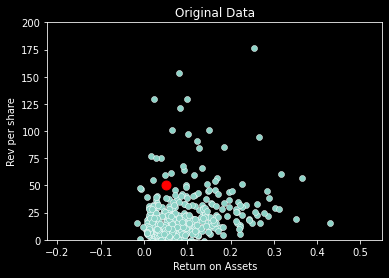

In [ ]:
# Visualize scatterplot
plt.style.use("dark_background")
g = sns.scatterplot(x='Return on Assets', y='Rev per share', data=data)
plt.ylim([0,200])
plt.title("Original Data")

# Some random point we want to classify
plt.scatter(0.05, 50, marker='o', s=80, color='red')

In [ ]:
# Both Revenue per share and Return on Assets are ratios. They are already scaled to the company size.
# We can use Winsorization to transforms data by limiting extreme values, typically by setting all outliers to a specified percentile of data
X =np.asarray([np.asarray(data['Return on Assets']),np.asarray(data['Rev per share'])])
X = mstats.winsorize(X, limits = [0.05, 0.05])
data=pd.DataFrame(X, index=['Return on Assets','Rev per share'], columns=data.index).T
data.head()

,Return on Assets,Rev per share
ID,,
FTI,0.012,-11.63
VTRS,-0.033,-13.10
LUMN,0.035,10.50
AMCR,0.056,23.80
HBAN,0.007,5.00


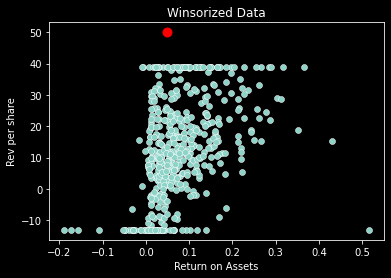

In [ ]:
# Visualize scatterplot
plt.style.use("dark_background")
g = sns.scatterplot(x='Return on Assets', y='Rev per share', data=data)
plt.title("Winsorized Data")

# Some random point we want to classify
plt.scatter(0.05, 50, marker='o', s=80, color='red')
plt.show()

### <I>3. Choose K (Elbow Method)</I>

The most common methods to choose K ( the appropriate number of clusters) :
    <ul>
        <li>**The Elbow Method** </li>
    </ul>

The silhouette coefficient is a value that ranges between -1 and 1. It quantifies how well a data point fits into its assigned cluster based on two factors:
1. How close the data point is to other points in the cluster
2. How far away the data point is from points in other clusters

Larger numbers for Silhouette coefficient indicate that samples are closer to their clusters than they are to other clusters.

The elbow method is used by running several k-means, increment k with each iteration, and record the SSE ( Sum Of Squared Error) <br><br>
$$SSE= Sum  \; Of  \; Euclidean  \; Squared  \; Distances  \; of  \; each  \; point \; to \; its  \; closest \; centroid $$<br>
After that , we plot SSE as a function of the number of clusters. SSE continues to decrease as you increase k. As more centroids are added, the distance from each point to its closest centroid will decrease.
There’s a sweet spot where the SSE curve starts to bend known as the elbow point. The x-value of this point is thought to be a reasonable trade-off between error and number of clusters. <br>

In [ ]:
distorsions = []
clusters_iterations=range(2, 20)
for k in clusters_iterations:
    k_means = KMeans(n_clusters=k)
    k_means.fit(data)
    distorsions.append(k_means.inertia_)

In [ ]:
elbow_curve_data=pd.DataFrame(zip(clusters_iterations,distorsions),columns=['Cluster','SSE']).set_index('Cluster')
elbow_curve_data.head()

,SSE
Cluster,
2,39365.539147
3,15981.510022
4,7564.358136
5,4648.628360
6,3047.015284


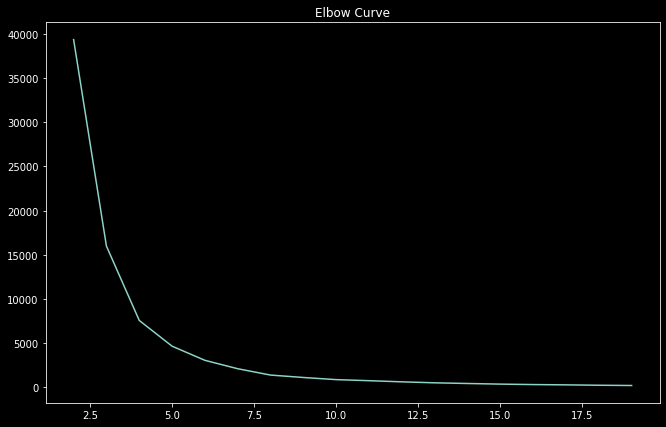

In [ ]:
# Visualize plot
plt.figure(figsize=(11,7))
plt.style.use("dark_background")
plt.plot(elbow_curve_data['SSE'])
plt.title("Elbow Curve")

plt.show()

In [ ]:
# get elbow programmatically
from kneed import KneeLocator 
kl = KneeLocator(
clusters_iterations, distorsions, curve="convex", direction="decreasing")
elbow=kl.elbow

print('Elbow = {}'.format(elbow))

Elbow = 5


### <I>4. Analyze the clustering results</I>

In [ ]:
# We apply KMeans for the Elbow's value  ( in this case = 5)
kmeans = KMeans(n_clusters=elbow)
kmeans.fit(data)
y_kmeans = kmeans.predict(data)
df_kmeans = data.copy()
df_kmeans['cluster']=y_kmeans.astype(str)

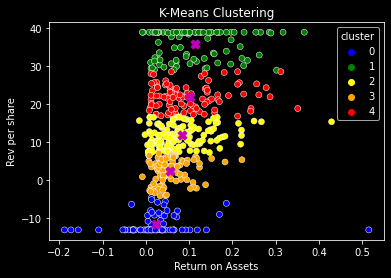

In [ ]:
# Visualize the results
plt.style.use("dark_background")
g = sns.scatterplot(x='Return on Assets', y='Rev per share', hue=df_kmeans['cluster'].astype(int), 
                    palette=['blue','green','yellow','orange','red'], data=df_kmeans)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
            marker="X", c="m", s=80, label="centroids")
plt.title("K-Means Clustering")

# Some random point we want to classify
plt.show()

In [ ]:
# see the centers 
clusters_centers_df=pd.DataFrame(kmeans.cluster_centers_,columns=['Return on Assets','Rev per share'])
clusters_centers_df

,Return on Assets,Rev per share
0,0.023360,-11.573200
1,0.114505,35.991895
2,0.082992,11.788110
3,0.056674,2.506522
4,0.101653,21.833663


In [ ]:
# See the clustering by Company 
clustering_result=pd.DataFrame(zip(y_kmeans,data.index),columns=['Cluster','Company'])
clustering_result.set_index('Cluster').head()

,Company
Cluster,
0,FTI
0,VTRS
2,LUMN
4,AMCR
3,HBAN


In [ ]:
for cluster_num in list(clustering_result.set_index('Cluster').index.unique()):
    print (clustering_result.set_index('Cluster').loc[cluster_num].head())

        Company
Cluster        
0           FTI
0          VTRS
0           AAL
0          NLSN
0           HST
        Company
Cluster        
2          LUMN
2           UAA
2           IVZ
2          NWSA
2          PARA
        Company
Cluster        
4          AMCR
4           KMI
4            RF
4           MRO
4          NLOK
        Company
Cluster        
3          HBAN
3           HPE
3           KIM
3           KEY
3             T
        Company
Cluster        
1             F
1           NWL
1          CTRA
1           BKR
1           CAG


In [ ]:
# Enrich Centers Df with the number of elements by Cluster
clusters_centers_df['Count']=clustering_result['Cluster'].value_counts().to_frame().rename(columns={'Cluster':'Count'})['Count']
clusters_centers_df.head()

,Return on Assets,Rev per share,Count
0,0.023360,-11.573200,75
1,0.114505,35.991895,95
2,0.082992,11.788110,127
3,0.056674,2.506522,92
4,0.101653,21.833663,101


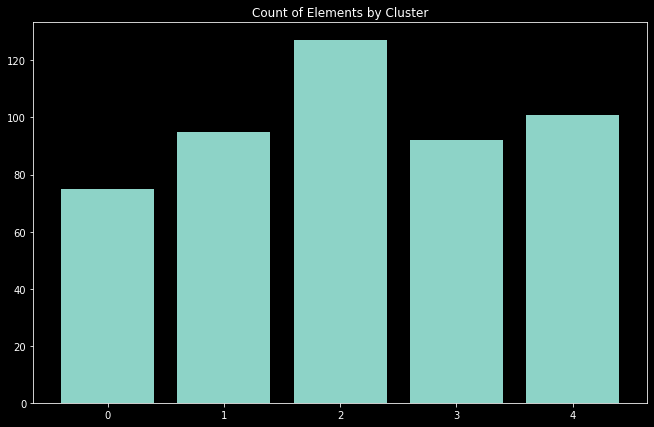

In [ ]:
# Visualize Count of Elements by Cluster 
plt.figure(figsize=(11,7))
plt.style.use("dark_background")
plt.bar(clusters_centers_df.index.values,clusters_centers_df['Count'])
plt.title("Count of Elements by Cluster")

plt.show()

## Portfolio Construction
### <I>1. From each cluster, choose the stocks with the highest Risk Adjusted Momentum </I>

We can use the 2 Year Historical Daily Prices endpoint from the ***yahoo finance*** to pull in the two year historical prices.

In [88]:
import yfinance as yf

In [119]:
df1 = yf.download(stock_symbol_list, start="2020-03-01", end="2022-03-01")

[*********************100%***********************]  505 of 505 completed


In [120]:
df1 = df1['Adj Close']
print(df1)

                     A        AAL  ...       ZION         ZTS
Date                               ...                       
2020-03-02   80.872940  18.860001  ...  39.593410  137.339890
2020-03-03   79.245033  17.850000  ...  37.292583  135.688736
2020-03-04   83.221077  18.530001  ...  36.889938  141.996643
2020-03-05   79.383156  16.040001  ...  34.608284  137.982513
2020-03-06   77.508575  15.970000  ...  33.822163  135.500900
...                ...        ...  ...        ...         ...
2022-02-22  130.490005  17.430000  ...  70.889999  190.100006
2022-02-23  126.000000  16.639999  ...  69.709999  187.059998
2022-02-24  128.149994  16.959999  ...  66.970001  190.949997
2022-02-25  133.729996  17.459999  ...  70.989998  194.710007
2022-02-28  130.360001  17.250000  ...  70.889999  193.649994

[504 rows x 505 columns]


In [121]:
df1.to_csv("stock daily price.csv")

[**************************121%****************************]  609 of 505 completed

In [122]:
# Build of Portfolio of 10 stocks
number_of_stocks=10

# From each Cluster, we will pick the stocks with the highest risk adjusted momentum. The number of stocks from each cluster is proportional to its size
# Let's start by calculate the number of stocks to pick from each cluster
number_of_stocks_by_cluster=pd.DataFrame(round(number_of_stocks*clustering_result.groupby(by='Cluster').count()['Company']/clustering_result.count()['Company'],0))
number_of_stocks_by_cluster

,Company
Cluster,
0,2.0
1,2.0
2,3.0
3,2.0
4,2.0


In [123]:
stock_daily_price_df = df1

[***************************125%*****************************]  629 of 505 completed

In [131]:
# From each Cluster, pick the stocks with the highest risk adjusted momentum.
as_of_date='2021-06-30'

portfolio_stocks=[]
for cluster_num in list(number_of_stocks_by_cluster.index):
    # for each cluster,get all the companies within this cluster
    list_stocks=list(clustering_result.set_index('Cluster').loc[cluster_num]['Company'])
    #get the number of stocks that we will pick for our portfolio     
    number_stocks=number_of_stocks_by_cluster.loc[cluster_num]['Company']
    if number_stocks>0:
        # Compute the risk adjusted momentum for the past year
        last_year_date=pd.to_datetime(as_of_date)+ pd.offsets.DateOffset(years=-1)
        last_month_date=pd.to_datetime(as_of_date)+ pd.tseries.offsets.BusinessDay(offset = timedelta(days = -30))
        stock_price_last_year_date = last_year_date.strftime('%Y-%m-%d')
        stock_price_last_month_date = last_month_date.strftime('%Y-%m-%d')
        
        risk_adjusted_mom_frames = []
        for ticker in list_stocks:

            try:
                momentum = (stock_daily_price_df .loc[stock_price_last_month_date,][ticker] - \
                            stock_daily_price_df .loc[stock_price_last_year_date,][ticker]) / \
                            stock_daily_price_df .loc[stock_price_last_year_date,][ticker]

                annualized_volatility = np.log(stock_daily_price_df .loc[stock_price_last_year_date:as_of_date,][ticker] / \
                                               stock_daily_price_df .loc[stock_price_last_year_date:as_of_date,][ticker].shift(1)).dropna().std()*252**.5

                risk_adjusted_momentum = momentum / annualized_volatility

                # Create Dataframe
                df = pd.DataFrame({'Risk Adj MoM': risk_adjusted_momentum},
                                  index=[ticker])

                risk_adjusted_mom_frames.append(df)

            except:
                pass

        risk_adjusted_mom_df = pd.concat(risk_adjusted_mom_frames, ignore_index=False)
        risk_adjusted_mom_df["Rank"] = risk_adjusted_mom_df["Risk Adj MoM"].rank(ascending=False)
        risk_adjusted_mom_df[["Risk Adj MoM", 
                              "Rank"]] = risk_adjusted_mom_df[["Risk Adj MoM", 
                                                               "Rank"]].apply(pd.to_numeric)
        filtered_risk_adjusted_mom_df = risk_adjusted_mom_df[risk_adjusted_mom_df['Rank'] <= number_stocks]
        portfolio_stocks=portfolio_stocks+list(filtered_risk_adjusted_mom_df.index)

portfolio_stocks

['BBWI', 'COF', 'NUE', 'DE', 'NWSA', 'TPR', 'JCI', 'PNR', 'TT', 'FCX', 'SIVB']

### <I> 2. Compute Portfolio's Performance for 2022-Q1 </I>

In [132]:
# Since we chose our portfolio stocks by end the of 2021-Q4, we will run it for 2022-Q1 
end_date='2022-03-01'

# Compute the portfolio return. We will use equal weights for all the stocks
stock_daily_price_df  = stock_daily_price_df .apply(pd.to_numeric)
s_p_500_daily_return = (stock_daily_price_df .loc[as_of_date:end_date,].pct_change().sum(axis=1).dropna()/len(stock_daily_price_df .columns)) + 1
cluster_portfolio_return=0
for stock in portfolio_stocks:
    daily_return = stock_daily_price_df .loc[as_of_date:end_date,][stock].pct_change().dropna() + 1
    cluster_portfolio_return=cluster_portfolio_return+(daily_return/len(portfolio_stocks))

# Create Dataframe
df = pd.DataFrame({'cluster_portfolio_return':cluster_portfolio_return,
                   'spx_index_return':s_p_500_daily_return},)

df.index.name = 'DATE'
return_ptf_index = df.dropna()
return_ptf_index = return_ptf_index.apply(pd.to_numeric)

return_ptf_index

,cluster_portfolio_return,spx_index_return
DATE,,
2021-07-01,1.007202,1.007118
2021-07-02,1.000126,1.002417
2021-07-06,0.982711,0.991619
2021-07-07,1.006642,1.002119
2021-07-08,0.981981,0.989799
...,...,...
2022-02-22,0.984509,0.990341
2022-02-23,0.981002,0.983627
2022-02-24,1.015385,1.011289


Portfolio Annual Excess Return : 3.74%
Portfolio Annual Volatility    : 23.43% 
Portfolio Sharpe Ratio         : 0.16


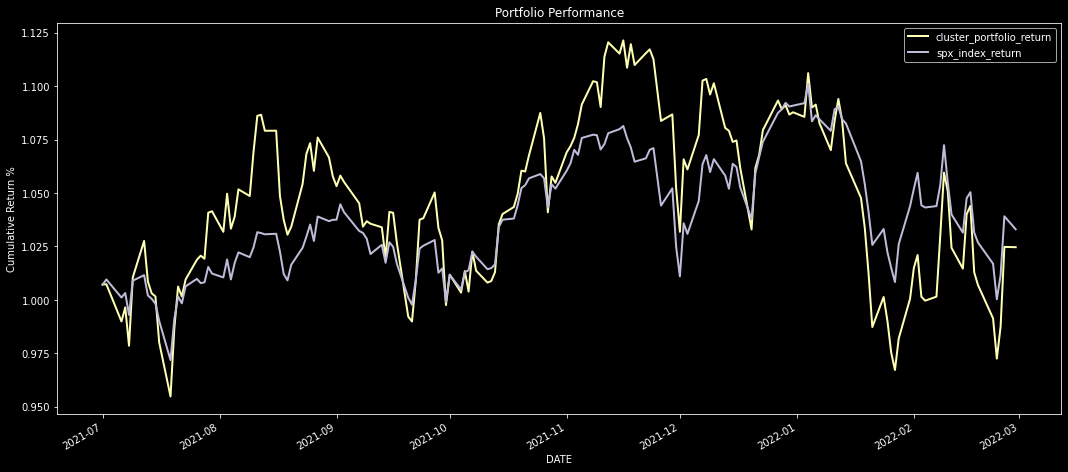

In [133]:
# Compute the annual volatility, sharpe ratio and annual excess return and plot the cumulative return
from math import sqrt

# compute the timeline for annualization
T = (pd.to_datetime(return_ptf_index['cluster_portfolio_return'].index[-1]) - pd.to_datetime(return_ptf_index['cluster_portfolio_return'].index[0])) / np.timedelta64(1, 'Y')

#portfolio Excess Return
portfolio_excess_return=round(100*(return_ptf_index['cluster_portfolio_return'].cumprod().iloc[-1]**(1/T) - 1),2)

#Portfolio Annual Volatility
portfolio_annual_volatility=round(100*return_ptf_index['cluster_portfolio_return'].std()*sqrt(252),2)

#Portfolio Sharpe Ratio
portfolio_sharpe_ratio=round((portfolio_excess_return)/portfolio_annual_volatility,2)

# Plot Results
print ("Portfolio Annual Excess Return : {}%".format(portfolio_excess_return))
print ("Portfolio Annual Volatility    : {}% ".format(portfolio_annual_volatility))
print ("Portfolio Sharpe Ratio         : {}".format(portfolio_sharpe_ratio)) 

plt.figure(figsize = (18,8))
ax = plt.gca()
plt.title("Portfolio Performance")
return_ptf_index['cluster_portfolio_return'].cumprod().plot(ax=ax,color=sns.color_palette()[1],linewidth=2)
return_ptf_index['spx_index_return'].cumprod().plot(ax=ax,color=sns.color_palette()[2],linewidth=2)
plt.ylabel("Cumulative Return %")
plt.legend()
plt.show()